## Discrete wavelet transformations on image data
A discrete wavelet transformation is an invertible (lossless) transformation of a signal, for example of an image, such that the information stored in the output is concentrated in fewer data points. In other words, the output is typically sparser.

In essence, what is stored in the output is both an **average of (original) data points** as well as the **difference between data points**. From this information, the original dataset (image) can be reconstructed.

Let us look at an example which explains this transformation (we will focus on the so-called *haar wavelets*). Assume that you are given a signal of the form

$$x = \begin{bmatrix} 22 & 22 & 27 & 26 & 38 & 34 & 6 & 7 & 5 & 5 \end{bmatrix}.$$

We will now store two $5$-dimensional vectors instead of this $10$-dimensional vector: The first one contains averages of consecutive entries of $x$. The second one contains the differences of consecutive entries of $x$. Formally, let $a_i := \frac{x_{2i-1} + x_{2i}}{2}$ and $d_i := \frac{x_{2i} - x_{2i-1}}{2}$. What we obtain is

$$a = \begin{bmatrix} 22 & 26.5 & 36 & 6.5 & 5 \end{bmatrix},\ \text{and} \ \begin{bmatrix} 0 & -1 & -4 & 1 & 0 \end{bmatrix}.$$

The same trick can be applied to image data, where (depending on the chosen transformation) we store an average of pixels and the difference between pixels horizontally, vertically and diagonally. Pixels which are close to each other often admit a similar color, leading to a sparser output.

*If you want more background information, the following presentation by Patrick J. Van Fleet gives a quick overview:
http://ceadserv1.nku.edu/longa/classes/2008spring/mat225/projects2/HaarTransform.pdf*

In what follows, we will use the package *PyWavelets* which implements such transformations and have a look at the output of a transformed image.

*Note / Copyright: I'm not too familiar with the correct usage of this package, which is why the code below is a modified version of the sample code provided here: https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html*

The original image contains 1919924 non-zero pixels.
Level 1: 962557 non-zero data points.
Level 2: 753834 non-zero data points.
Level 3: 699422 non-zero data points.


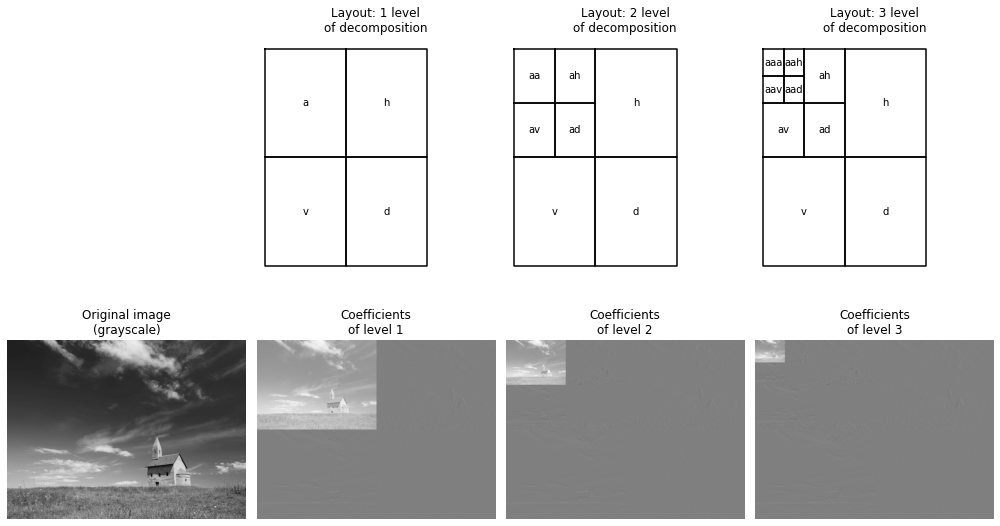

In [3]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import requests
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from PIL import Image
from io import BytesIO

# Image by pipo99, https://www.freeimages.com/photo/church-1217701
url = "https://images.freeimages.com/images/large-previews/8ca/church-1217701.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('L')
imagemat = np.array(image, dtype="float32") / 255.0
print("The original image contains " + str(len(imagemat.flat[imagemat.flat > 0])) + " non-zero pixels.")

fig, axes = plt.subplots(2, 4, figsize=[14, 8])

for level in range(0, 4):
    if level == 0:
        axes[0,0].axis("off")
        axes[1,0].set_title("Original image\n(grayscale)")
        axes[1,0].imshow(imagemat, cmap="gray")
        axes[1,0].axis("off")
        continue
    
    # The following command draws a graphical illustration of the data
    # contained in the output of the wavelet transform
    draw_2d_wp_basis(imagemat.shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=3)
    axes[0, level].set_title('Layout: {} level\nof decomposition'.format(level))

    # Computation of the 2D discrete wavelet transformation of imagemat
    c = pywt.wavedec2(imagemat, 'haar', mode='periodization', level=level)
    
    # Normalize the coefficients for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
        
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap="gray")
    axes[1, level].set_title('Coefficients\nof level {}'.format(level))
    axes[1, level].set_axis_off()
    
    print("Level {}: {} non-zero data points.".format(level, str(len(arr.flat[arr.flat > 0]))))

plt.tight_layout()
plt.show()

The first image shows the original (grayscale) input data, while the other three show the output of one, two and three consecutive applications of the discrete wavelet transformation on the input matrix. In the first level of decomposition, the matrix $a$ contains averages, while $h$, $v$ and $d$ consist essentially of the differences between pixels horizontally, diagonally and vertically.

While the resulting images (i.e., the output matrices) admit less non-zero entries compared to the original image, the support is still significantly large. However, many entries of the output data are very small and similar to each other (the gray areas). The idea behind compression techniques such as JPEG is to exploit this property: First, **quantize** the output, i.e., replace similar pixel values by the same value, and subsequently encode the quantized image.